<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico Integrador </font></h1>
    <h2><font style="bold">Visión por Computadora II - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pedro Barrera - Ezequiel Caamaño</font></h3>
</div>

# Detección Automatizada de Cáncer de Pulmón mediante Visión por Computadora

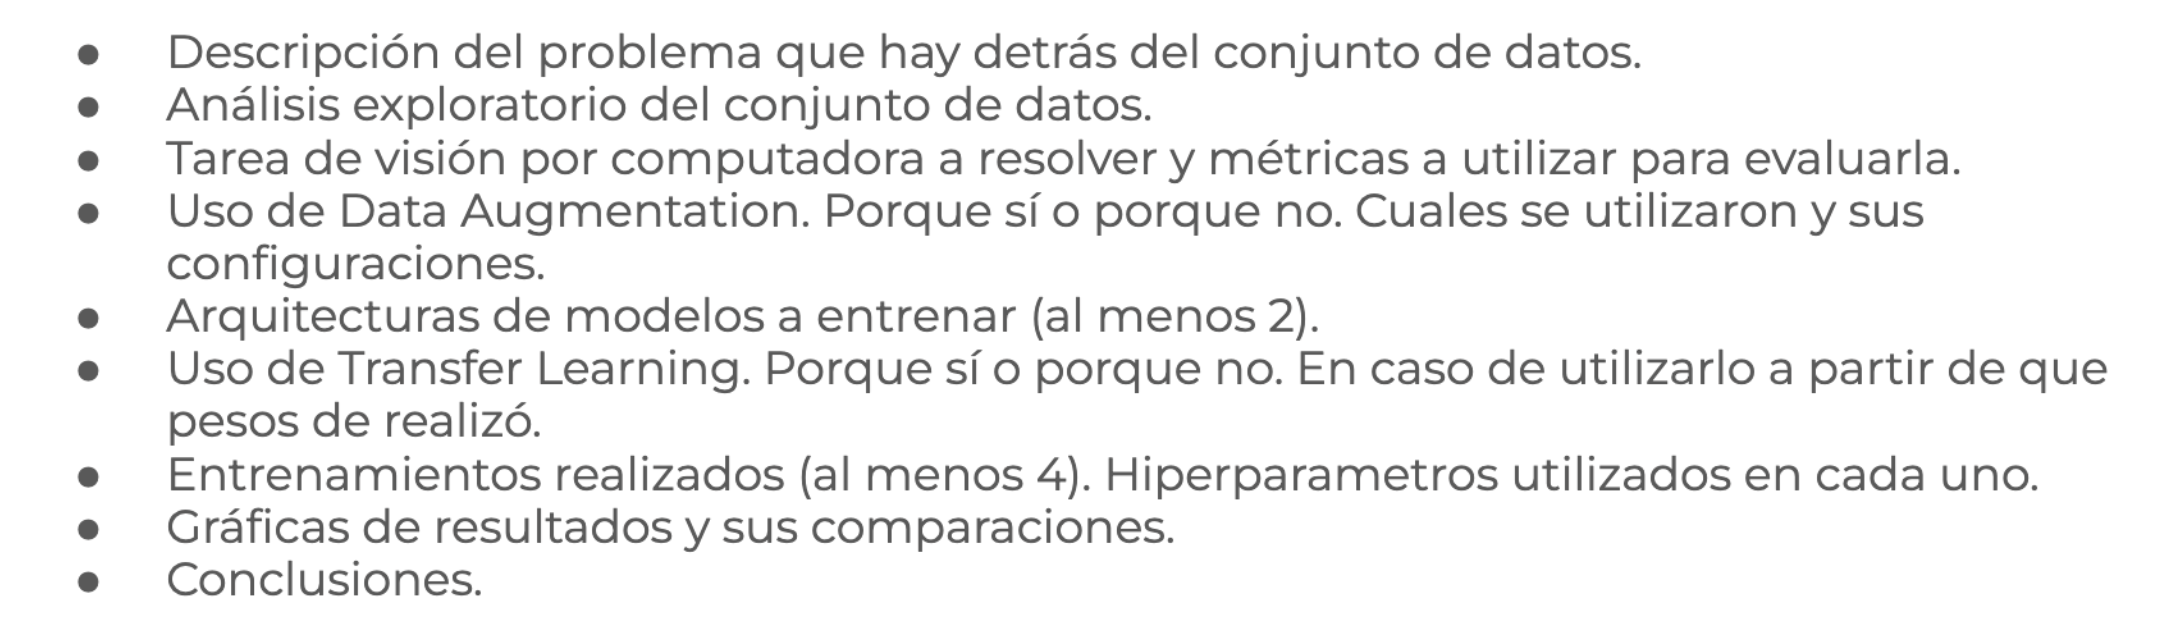

## Business Case

**Motivación:**

El cáncer de pulmón es una de las principales causas de muerte a nivel mundial. Su detección temprana es crucial para mejorar el pronóstico y las posibilidades de tratamiento de los pacientes. Sin embargo, los métodos tradicionales de diagnóstico dependen fuertemente de la interpretación humana de imágenes médicas, lo cual puede estar sujeto a errores, demoras y variabilidad entre profesionales.

Ante este desafío, las técnicas de visión por computadora y aprendizaje automático ofrecen una oportunidad: automatizar la detección y clasificación de distintos tipos de cáncer pulmonar a partir de imágenes, asistiendo al cuerpo médico en el proceso diagnóstico y permitiendo un análisis más rápido, objetivo y escalable.

**Objetivo:**

Desarrollar un sistema inteligente basado en redes neuronales convolucionales (CNN) que sea capaz de analizar imágenes de tomografías de tórax (CT-Scans) y:
- Detectar si el paciente presenta o no signos de cáncer.
- Clasificar el tipo de cáncer entre:
    - *Adenocarcinoma:* es la forma más común de cáncer de pulmón, representando aproximadamente el 30% de todos los casos y cerca del 40% de los casos de cáncer de pulmón de células no pequeñas (NSCLC).
    - *Carcinoma de células grandes:* es un tipo de cáncer de pulmón que crece y se disemina rápidamente, y puede aparecer en cualquier parte del pulmón. Representa entre el 10% y el 15% de los casos de cáncer de pulmón de células no pequeñas.
    - *Carcinoma de células escamosas:* se localiza en la parte central del pulmón, generalmente donde los bronquios principales se conectan con la tráquea o en una de las principales ramas de las vías respiratorias.

**Justificación:**

Este proyecto tiene un fuerte impacto potencial en varios niveles:

*Impacto Clínico:*
- Reducción del tiempo diagnóstico.
- Mayor precisión y objetividad al identificar tipos específicos de cáncer.
- Asistencia a radiólogos y oncólogos con una herramienta complementaria.

*Impacto Social:*
- Mejora en la calidad de vida de los pacientes mediante una detección temprana.
- Democratización del acceso al diagnóstico, especialmente en regiones con escasez de especialistas.

*Impacto Económico:*
- Reducción de costos médicos derivados de diagnósticos tardíos o tratamientos inadecuados.
- Optimización de recursos en instituciones de salud.

## Exploratory Data Analysis

### Importación de Librerias

In [2]:
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

### Importación del Dataset

**Descripción del Dataset**

Se utilizó el dataset **Chest CT Scan Images** disponible en [Kaggle](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images). Contiene imágenes de tomografías de tórax clasificadas en:

- Adenocarcinoma  
- Carcinoma de células grandes  
- Carcinoma de células escamosas  
- Células normales

Las imágenes están en formato `.jpg` o `.png`, y se organizan en tres subconjuntos: `train` (70%), `valid` (10%) y `test` (20%).

> Fuente: [Mohamed Hany – Chest CT Scan Images Dataset](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)

In [4]:
# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /Users/anoguera/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


In [5]:
# Ruta al directorio "Data" que contiene train/valid/test
data_dir = os.path.join(path, "Data")

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # redimensionar imágenes
    transforms.ToTensor(),           # convertir a tensor
])

# Cargar datasets desde carpetas
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, "test"),  transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

### Introducción General

In [7]:
# Cantidad de Imágenes
print("Cantidad de imágenes en el conjunto de entrenamiento:", len(train_dataset))
print("Cantidad de imágenes en el conjunto de validación:", len(valid_dataset))
print("Cantidad de imágenes en el conjunto de prueba:", len(test_dataset))

Cantidad de imágenes en el conjunto de entrenamiento: 613
Cantidad de imágenes en el conjunto de validación: 72
Cantidad de imágenes en el conjunto de prueba: 315


In [8]:
# Clases detectadas
print("Clases:", train_dataset.classes)

Clases: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


### Desbalance de Clases

### Análisis de Distribución de Colores

### Análisis de Bounding Boxes

### Análisis de Distribución de Etiquetas

### Dimensión de Imágenes y Relación de Aspecto

### Calidad de Imágenes